In [1]:
# Import the required classes
from pyspark import SparkConf
import pyspark.sql.types
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.clustering import KMeans

# 1. 1. Data preparation and exploration (35%)
## 1.1 Creating Spark Session (4%)

In [2]:
# 1.1.1
# 1.1.2
# Set working processors to number of logical cores on the machine
master = "local[*]"
# Name to be shown on Spark cluster UI page
app_name = "Assignment 2A: Detecting Linux system hacking activities"

# setting configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes 
from pyspark import SparkContext
from pyspark.sql import SparkSession

# Building SparkSession and modyfying the config to make 4 partitions for each df
spark = SparkSession.builder.config(conf=spark_conf).config("spark.sql.files.maxPartitionBytes", 34078720).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## 1.2 Loading the data (16%)

In [3]:
# 1.2.1
# Defining the process schema using the metadata
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType, DoubleType
pro_schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("TRUN", IntegerType()),
    StructField("TSLPI", IntegerType()),
    StructField("TSLPU", IntegerType()),
    StructField("POLI", StringType()),
    StructField("NICE", IntegerType()),
    StructField("PRI", IntegerType()),
    StructField("RTPR", IntegerType()),
    StructField("CPUNR", IntegerType()),
    StructField("Status", StringType()),
    StructField("EXC", IntegerType()),
    StructField("State", StringType()),
    StructField("CPU", DoubleType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType())
])

In [4]:
# 1.2.1
# Defining the memory schema using the metadata
temp_mem_schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("MINFLT", IntegerType()),
    StructField("MAJFLT", IntegerType()),
    StructField("VSTEXT", IntegerType()),
    StructField("VSIZE", IntegerType()),
    StructField("RSIZE", DoubleType()),
    StructField("VGROW", IntegerType()),
    StructField("RGROW", DoubleType()),
    StructField("MEM", DoubleType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType())
])

In [5]:
# 1.2.1
# Reading the data acccording to the above schema
process_df = spark.read.csv('linux_p*.csv', header = True, schema = pro_schema)
temp_mem_df = spark.read.csv('linux_m*.csv', header = True, schema = temp_mem_schema)

In [6]:
# 1.2.1
# Row count for each df
print(process_df.count())
print(temp_mem_df.count())

1927968
2000000


In [7]:
# 1.2.2
# Checking for nulls
check_pro = process_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in process_df.columns])
check_pro.show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



In [8]:
# 1.2.2
# Checking for nulls
check_mem = temp_mem_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in temp_mem_df.columns])
check_mem.show()

+---+---+------+------+------+------+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT| VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+------+-----+-----+-----+---+---+------+----+
|  0|  0|  9737|448868| 27907|523958| 9728|50912| 9737|  0|  0|     0|   0|
+---+---+------+------+------+------+-----+-----+-----+---+---+------+----+



#### Here we observe that the process schema follows the metadata file since it doesn't contain null values while the memory schema doesn't and has a lot of null values. Therefore, we import the data as StringType() and then modify it according to our needs in the next few steps.

In [9]:
# 1.2.1
# Defining the memory schema again
mem_schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("MINFLT", StringType()),
    StructField("MAJFLT", StringType()),
    StructField("VSTEXT", StringType()),
    StructField("VSIZE", DoubleType()),
    StructField("RSIZE", StringType()),
    StructField("VGROW", StringType()),
    StructField("RGROW", StringType()),
    StructField("MEM", DoubleType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType())
])

In [10]:
# 1.2.1
# Reading the data acccording to the above schema
memory_df = spark.read.csv('linux_m*.csv', header = True, schema = mem_schema)

In [11]:
# 1.1.1
# caching the data
memory_df.cache()
process_df.cache()

DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: double, CMD: string, attack: int, type: string]

In [12]:
# 1.2.2
# Checking for nulls
check_mem = memory_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in memory_df.columns])
check_mem.show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



#### We observe that the columns 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW' in memory data do not follow the datatype from the metadata file therefore we import them in StringType() and transform them in the following steps.

In [13]:
# 1.2.2
# Replacing K with 0000s
# Using substring to remove K and typecast the data to int
# Multiply by 1000 after typecasting
memory_df = memory_df.withColumn('MINFLT',\
                     F.when(col("MINFLT").contains('K'),\
                            expr("substring(MINFLT, 1, length(MINFLT)-1)")\
                            .cast('int')*1000).otherwise(col("MINFLT").cast('int')))

In [14]:
# 1.2.2
# Replacing M with 000000s
# Using substring to remove M and typecast the data to int
# Multiply by 1000000 after typecasting
memory_df = memory_df.withColumn('MAJFLT',\
                 F.when(col("MAJFLT").contains('M'),\
                        expr("substring(MAJFLT, 1, length(MAJFLT)-1)")\
                        .cast('double')*1000000).otherwise(col("MAJFLT").cast('double')))

In [15]:
# 1.2.2
# Replacing K with 0000s
# Using substring to remove K and typecast the data to int
# Multiply by 1000 after typecasting
memory_df = memory_df.withColumn('VSTEXT',\
                 F.when(col("VSTEXT").contains('K'),\
                        expr("substring(VSTEXT, 1, length(VSTEXT)-1)")\
                        .cast('double')*1000).otherwise(col("VSTEXT").cast('double')))

In [16]:
# 1.2.2
# Replacing M with 000000s
# Using substring to remove M and typecast the data to int
# Multiply by 1000000 after typecasting
memory_df = memory_df.withColumn('RSIZE',\
                 F.when(col("RSIZE").contains('M'),\
                        expr("substring(RSIZE, 1, length(RSIZE)-1)")\
                        .cast('double')*1000000).otherwise(col("RSIZE")))

In [17]:
# 1.2.2
# Replacing K with 0000s
# Using substring to remove K and typecast the data to int
# Multiply by 1000 after typecasting
memory_df = memory_df.withColumn('RSIZE',\
                 F.when(col("RSIZE").contains('K'),\
                        expr("substring(RSIZE, 1, length(RSIZE)-1)")\
                        .cast('double')*1000).otherwise(col("RSIZE").cast('double')))

In [18]:
# 1.2.2
# Removing spaces from between numbers
memory_df = memory_df.withColumn('VGROW', regexp_replace(col('VGROW'), ' ', ''))

In [19]:
# 1.2.2
# Replacing K with 0000s
# Using substring to remove K and typecast the data to int
# Multiply by 1000 after typecasting
memory_df = memory_df.withColumn('VGROW',\
                 F.when(col("VGROW").contains('K'),\
                        expr("substring(VGROW, 1, length(VGROW)-1)")\
                        .cast('double')*1000).otherwise(col("VGROW").cast('double')))

In [20]:
# 1.2.2
# Replacing K with 0000s
# Using substring to remove K and typecast the data to int
# Multiply by 1000 after typecasting
memory_df = memory_df.withColumn('RGROW',\
                 F.when(col("RGROW").contains('K'),\
                        expr("substring(RGROW, 1, length(RGROW)-1)")\
                        .cast('double')*1000).otherwise(col("RGROW").cast('double')))

In [21]:
# 1.2.2
# checking for nulls
check_mem = memory_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in memory_df.columns])
check_mem.show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



### 1.3 Exploring the data (15%)

In [22]:
# 1.3.1
# Groupby attack and count cases
print("Attack count for Memory Dataframe")
memory_df.groupby('attack').agg(F.count('attack').alias('Count')).show()
# Groupby type and count cases
print("Type count for Memory Dataframe")
memory_df.groupby('type').agg(F.count('type').alias('Count')).show()

Attack count for Memory Dataframe
+------+-------+
|attack|  Count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+

Type count for Memory Dataframe
+---------+-------+
|     type|  Count|
+---------+-------+
| password|  26016|
|     ddos|  45689|
|   normal|1794377|
|     mitm|    112|
|injection|  58523|
|      dos|  75283|
+---------+-------+



In [23]:
# 1.3.1
# Groupby attack and count cases
print("Attack count for Process Dataframe")
process_df.groupby('attack').agg(F.count('attack').alias('Count')).show()
# Groupby type and count cases
print("Type count for Process Dataframe")
process_df.groupby('type').agg(F.count('type').alias('Count')).show()

Attack count for Process Dataframe
+------+-------+
|attack|  Count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+

Type count for Process Dataframe
+---------+-------+
|     type|  Count|
+---------+-------+
|      xss|  17759|
| password|  51409|
| scanning|  38449|
|     ddos|  71603|
|   normal|1636604|
|     mitm|    112|
|injection|  41311|
|      dos|  70721|
+---------+-------+



#### We can see that for both Process and Memory data the data is biased since there are very less number of attacks than the number of non-attacks. Also, the Normal type means that it is a non-attack. The number of ddos and dos type attacks are the most common types of attack and mtim is the least common attack type.

In [24]:
# 1.3.2
# Displaying basic statistics for numerical columns for memory dataframe
cols = {'ts', 'PID', 'MINFLT', 'MAJFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'VGROW', 'RGROW', 'MEM'}
for column in cols:
    memory_df.describe(column).show()

+-------+------------------+
|summary|             RSIZE|
+-------+------------------+
|  count|           2000000|
|   mean|23722.888664202153|
| stddev|1986383.1808735176|
|    min|           -9728.0|
|    max|           2.244E8|
+-------+------------------+

+-------+-----------------+
|summary|           VSTEXT|
+-------+-----------------+
|  count|          2000000|
|   mean|46453.27415208929|
| stddev|658730.2051543014|
|    min|              0.0|
|    max|           1.12E7|
+-------+-----------------+

+-------+------------------+
|summary|             RGROW|
+-------+------------------+
|  count|           2000000|
|   mean|483.17466254999994|
| stddev|1491.4761059171776|
|    min|               0.0|
|    max|           98920.0|
+-------+------------------+

+-------+--------------------+
|summary|                 MEM|
+-------+--------------------+
|  count|             2000000|
|   mean|0.003385165000001646|
| stddev|0.010943425779985829|
|    min|                 0.0|
|    m

In [25]:
# 1.3.2
# Diplaying the top 10 counts for CMD column in Memory dataframe
memory_df.groupby('CMD').agg(F.count('CMD').alias('Count')).sort("Count", ascending=False).show(10)

+----------+------+
|       CMD| Count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



In [26]:
# 1.3.2
# Displaying basic statistics for numerical columns for process dataframe
cols = {'ts', 'PID', 'TRUN' , 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'RTPR', 'CPUNR', 'EXC', 'CPU'}
for column in cols:
    process_df.describe(column).show()

+-------+-----------------+
|summary|             NICE|
+-------+-----------------+
|  count|          1927968|
|   mean|4.634469555511295|
| stddev|8.403189864752083|
|    min|                0|
|    max|               20|
+-------+-----------------+

+-------+--------------------+
|summary|               TSLPU|
+-------+--------------------+
|  count|             1927968|
|   mean|3.610018423542299...|
| stddev| 0.04421874419214598|
|    min|                   0|
|    max|                  21|
+-------+--------------------+

+-------+-------------------+
|summary|               TRUN|
+-------+-------------------+
|  count|            1927968|
|   mean| 0.0632287465352122|
| stddev|0.24782587090416033|
|    min|                  0|
|    max|                 12|
+-------+-------------------+

+-------+-----------------+
|summary|              PID|
+-------+-----------------+
|  count|          1927968|
|   mean|5068.709770597852|
| stddev|4987.784329320444|
|    min|             1007|


In [27]:
# 1.3.2
# Diplaying the top 10 counts for POLI, Status, State abd CMD column in Process dataframe
process_df.groupby('POLI').agg(F.count('POLI').alias('Count')).sort("Count", ascending=False).show(10)
process_df.groupby('Status').agg(F.count('Status').alias('Count')).sort("Count", ascending=False).show(10)
process_df.groupby('State').agg(F.count('State').alias('Count')).sort("Count", ascending=False).show(10)
process_df.groupby('CMD').agg(F.count('CMD').alias('Count')).sort("Count", ascending=False).show(10)

+----+-------+
|POLI|  Count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  Count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  Count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| Count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



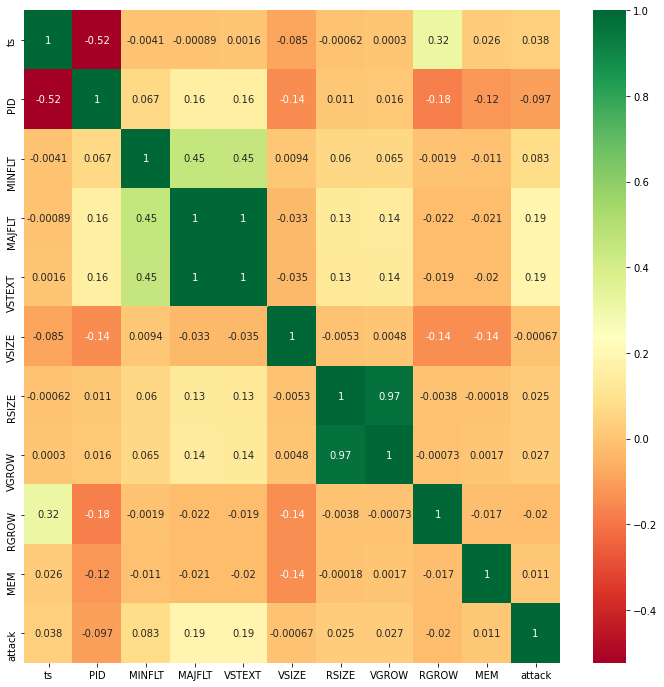

In [28]:
# 1.3.3
# converting both memory and process data to pandas df for visualization
pan_memory = memory_df.toPandas()
pan_process = process_df.toPandas()
a = pan_memory.corr()
b = pan_process.corr()
b = b.drop('RTPR', axis=1)
b = b.drop('RTPR', axis=0)
corr_features = a.index
plt.figure(figsize=(12,12))
# Plot correlation heat map for memory df
g = sns.heatmap(pan_memory[corr_features].corr(), annot=True, cmap="RdYlGn")

#### Here we observe that the correlation coefficient of attack with all the other variables is quite low for the memory dataframe. A few of the variables like MAJFLT, VGROW etc. are highly correlated with the other variables.

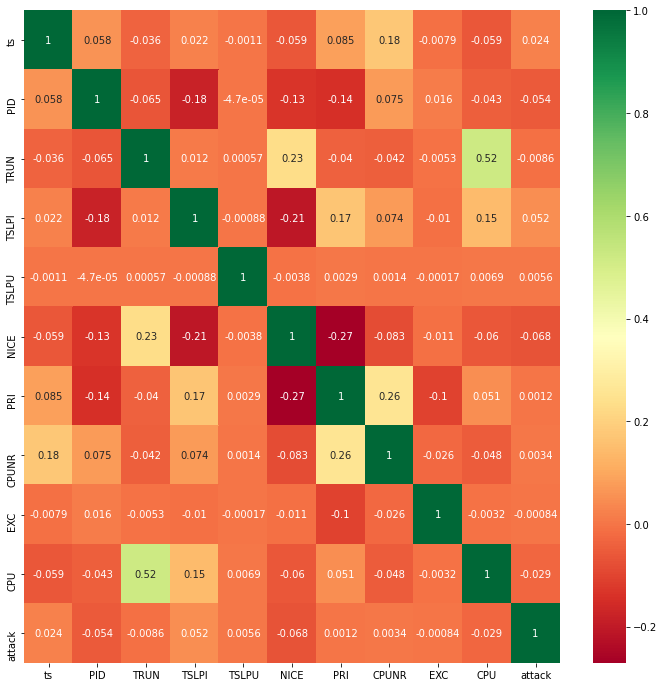

In [29]:
# 1.3.3
corr_features = b.index
plt.figure(figsize=(12,12))
# Plot correlation heat map for process df
g = sns.heatmap(pan_process[corr_features].corr(), annot=True, cmap="RdYlGn")

#### Here we observe that the correlation coefficient of attack with all the other variables is quite low for the memory dataframe. Unlike memory dataframe we do not observe any high correlation among the variables of the process dataframe.

<AxesSubplot:xlabel='attack', ylabel='VGROW'>

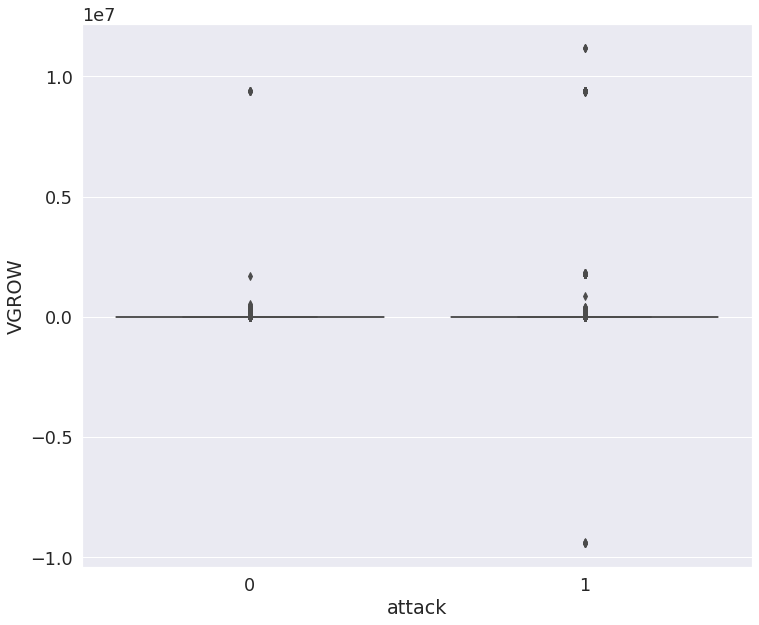

In [30]:
# 1.3.3
# Boxplot attack vs VGROW
sns.set(font_scale=1.6, rc={'figure.figsize':(12, 10)})
sns.boxplot(x='attack', y='VGROW', data=pan_memory)

#### Majority of the data for VGROW is scattered around 0 with multiple outliers. Distingishing between classes using just a single variable seems to be impossible.

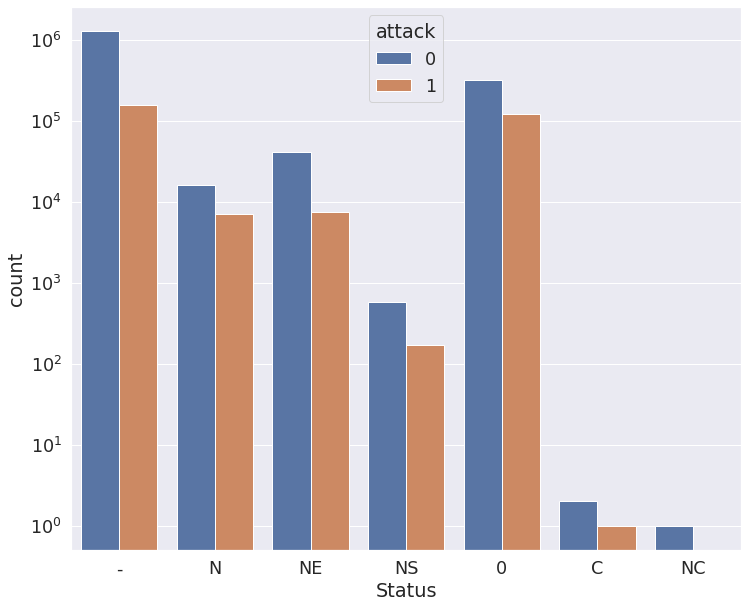

In [31]:
# 1.3.3
# Histogram of Status with attacks and non-attacks
sns.countplot(x="Status", hue="attack", data=pan_process)
plt.yscale('log')

#### We observe that the variables status doesn't differentiate much among the classes attack and non-attack and therefore we cannot say that a particular status will cause an attack or not.

## 2. Feature extraction and ML training (55%)
### 2.1 Preparing the training data and testing data (4%)

In [32]:
# 2.1.1
# Splitting data into train and test for both datasets
train_mem, test_mem = memory_df.randomSplit([0.8, 0.2], seed=30192)
train_pro, test_pro = process_df.randomSplit([0.8, 0.2], seed = 30192)

In [33]:
# 2.1.2
# Count of 20% attacks in memory training data 
train_mem.sampleBy("attack", fractions={0: 0, 1: 0.2}, seed=30192).count()

32790

In [34]:
# 2.1.2
# Count of original attacks and non-attacks
train_mem.groupby('attack').agg(F.count('attack').alias('Count')).show()

+------+-------+
|attack|  Count|
+------+-------+
|     1| 164306|
|     0|1435206|
+------+-------+



In [35]:
# 2.1.2
# Balanced data with 1:2 ratio for attacks and non-attacks
# 0.046 = 32790*2/1435206
sampled_mem = train_mem.sampleBy("attack", fractions={0: 0.046, 1: 0.2}, seed=30192)
sampled_mem.groupby('attack').agg(F.count('attack').alias('Count')).show()

+------+-----+
|attack|Count|
+------+-----+
|     1|32790|
|     0|65659|
+------+-----+



In [36]:
# 2.1.2
# Count of 20% attacks in process training data 
train_pro.sampleBy("attack", fractions={0: 0, 1: 0.2}, seed=30192).count()

46299

In [37]:
# 2.1.2
# Count of original attacks and non-attacks
train_pro.groupby('attack').agg(F.count('attack').alias('Count')).show()

+------+-------+
|attack|  Count|
+------+-------+
|     1| 232969|
|     0|1308726|
+------+-------+



In [38]:
# 2.1.2
# Balanced data with 1:2 ratio for attacks and non-attacks
# 0.071 = 46299*2/1308726
sampled_pro = train_pro.sampleBy("attack", fractions={0: 0.071, 1: 0.2}, seed=30192)
sampled_pro.groupby('attack').agg(F.count('attack').alias('Count')).show()

+------+-----+
|attack|Count|
+------+-----+
|     1|46299|
|     0|92647|
+------+-----+



In [39]:
# 2.1.2
# caching the dataframes for fast access
sampled_pro.cache()
sampled_mem.cache()

DataFrame[ts: int, PID: int, MINFLT: int, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: int, type: string]

### 2.2 Preparing features, labels and models (16%)

#### 2.2.1
#### Looking at the correlation plot for memory data we can exclude the variables MAJFLT and VGROW from the training models. Also, the variables ts, PID and type can be dropped from our analysis.
#### Looking at the correlation plot for process data we observe that none of the variables are correlated with the attacks. Therefore, we exclude the variables ts, PID and type from our analysis.

In [40]:
# Defining the decision tree classifier
decisionTree = DecisionTreeClassifier(featuresCol='features', labelCol='attack', maxDepth = 3)
# Defining the Gradient Boosted Tree classifier
gradientTree = GBTClassifier(featuresCol='features', labelCol='attack', maxIter = 5)

In [41]:
# 2.2.2
# Defining the string indexer 
inputIndexer = StringIndexer(inputCols=['CMD'], outputCols=['CMD_index']).setHandleInvalid("keep")
# Defining OHE
encoder = OneHotEncoder(inputCols=['CMD_index'], outputCols=['CMD_vec'])
# Columns with datatype integer or double
numericCols = ['MINFLT', 'VSTEXT', 'VSIZE', 'RSIZE', 'RGROW', 'MEM']
# Combining the numerical and categorical columns
assemblerInputs = ['CMD_vec'] + numericCols
# Defining the vector assembler
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [42]:
# 2.2.3
# Initializing stages for pipelining
stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler
stage_4A = decisionTree
stage_4B = gradientTree
stages_dt = [stage_1,stage_2,stage_3,stage_4A]
stages_gbt = [stage_1,stage_2,stage_3,stage_4B]
# Defining the pipelines
pipe_mem_dt = Pipeline(stages = stages_dt)
pipe_mem_gbt = Pipeline(stages = stages_gbt)

In [43]:
# 2.2.2
# Defining the string indexer 
inputIndexer = StringIndexer(inputCols=['POLI', 'Status', 'CMD'], outputCols=['POLI_index', 'Status_index', 'CMD_index']).setHandleInvalid("keep")
# Defining OHE
encoder = OneHotEncoder(inputCols=['POLI_index', 'Status_index', 'CMD_index'], outputCols=['POLI_vec', 'Status_vec', 'CMD_vec'])
# Columns with datatype integer or double
numericInputCols = ['TRUN', 'NICE', 'PRI', 'RTPR', 'CPUNR', 'CPU']
# Defining the vector assembler
inputCols=['POLI_vec', 'Status_vec', 'CMD_vec']
assemblerInputs = inputCols + numericInputCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [44]:
# 2.2.3
# Initializing stages for pipelining
stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler
stage_4A = decisionTree
stage_4B = gradientTree
stages_dt = [stage_1,stage_2,stage_3,stage_4A]
stages_gbt = [stage_1,stage_2,stage_3,stage_4B]
# Defining the pipeline
pipe_pro_dt = Pipeline(stages = stages_dt)
pipe_pro_gbt = Pipeline(stages = stages_gbt)

### 2.3 Training and evaluating models (35%)

In [45]:
# 2.3.1
# Fitting the model to train data for memory dataset
mem_dt = pipe_mem_dt.fit(sampled_mem)
# Prediction for the test data using decision tree classifier
pred_mem_dt = mem_dt.transform(test_mem)

In [46]:
# 2.3.1
# Fitting the model to train data for memory dataset
mem_gbt = pipe_mem_gbt.fit(sampled_mem)
# Prediction for the test data using gradient boosted tree classifier
pred_mem_gbt = mem_gbt.transform(test_mem)

In [47]:
# 2.3.1
# Fitting the model to train data for process dataset
pro_dt = pipe_pro_dt.fit(sampled_pro)
# Prediction for the test data using decision tree classifier
pred_pro_dt = pro_dt.transform(test_pro)

In [48]:
# 2.3.1
# Fitting the model to train data for process dataset
pro_gbt = pipe_pro_gbt.fit(sampled_pro)
# Prediction for the test data using decision tree classifier
pred_pro_gbt = pro_gbt.transform(test_pro)

In [49]:
# 2.3.2 and 2.3.3 and 2.3.4
# Defining a function that prints the model summary stats 
def model_eval(pred_df):
    # True negatives 
    TN = pred_df.filter('prediction = 0 AND attack = 0').count()
    # True positives
    TP = pred_df.filter('prediction = 1 AND attack = 1').count()
    # False positives
    FP = pred_df.filter('prediction = 1 AND attack = 0').count()
    # False negatives
    FN = pred_df.filter('prediction = 0 AND attack = 1').count()
    # Summary stats
    accuracy = (TN+TP)/(TN+TP+FN+FP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*((precision*recall)/(precision+recall))
    # AUC evaluator
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol = 'attack')
    # Confusion matrix
    pred_df.groupBy('attack', 'prediction').count().show()
    print("Summary Stats")
    print("Accuracy = %s" % accuracy)
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1)
    print("Area Under ROC(AUC): " + str(evaluator.evaluate(pred_df, {evaluator.metricName: "areaUnderROC"})))

In [50]:
# 2.3.2 and 2.3.3 
print("Confusion matrix and Summary Stats for Decision Tree - Memory Data")
model_eval(pred_mem_dt)

Confusion matrix and Summary Stats for Decision Tree - Memory Data
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 31375|
|     0|       0.0|336386|
|     1|       1.0|  9942|
|     0|       1.0| 22785|
+------+----------+------+

Summary Stats
Accuracy = 0.8647649867162063
Precision = 0.3037858648822074
Recall = 0.2406273446765254
F1 Score = 0.26854302846955863
Area Under ROC(AUC): 0.38511418866942493


In [51]:
# 2.3.2 and 2.3.3
print("Confusion matrix and Summary Stats for Gradient Boosted Tree - Memory Data")
model_eval(pred_mem_gbt)

Confusion matrix and Summary Stats for Gradient Boosted Tree - Memory Data
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 26622|
|     0|       0.0|332520|
|     1|       1.0| 14695|
|     0|       1.0| 26651|
+------+----------+------+

Summary Stats
Accuracy = 0.8669797846627115
Precision = 0.35541527596381756
Recall = 0.3556647384853692
F1 Score = 0.3555399634661215
Area Under ROC(AUC): 0.8000770744648162


In [52]:
# 2.3.2 and 2.3.3
print("Confusion matrix and Summary Stats for Decison Tree - Process Data")
model_eval(pred_pro_dt)

Confusion matrix and Summary Stats for Decison Tree - Process Data
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 38424|
|     0|       0.0|292078|
|     1|       1.0| 19971|
|     0|       1.0| 35800|
+------+----------+------+

Summary Stats
Accuracy = 0.807845746402156
Precision = 0.3580893295798892
Recall = 0.3419984587721551
F1 Score = 0.34985897727869947
Area Under ROC(AUC): 0.38715437821218174


In [53]:
# 2.3.2 and 2.3.3
print("Confusion matrix and Summary Stats for Gradient Boosted Tree - Process Data")
model_eval(pred_pro_gbt)

Confusion matrix and Summary Stats for Gradient Boosted Tree - Process Data
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 37123|
|     0|       0.0|291332|
|     1|       1.0| 21272|
|     0|       1.0| 36546|
+------+----------+------+

Summary Stats
Accuracy = 0.8092825540485615
Precision = 0.36791310664498944
Recall = 0.3642777635071496
F1 Score = 0.3660864102983315
Area Under ROC(AUC): 0.7176007029895348


#### 2.3.3
#### We observe that our models are good at predicting the TRUE NEGATIVES but doesn't perform well at predicting the TRUE POSITIVES. Therefore, we should use a balanced metric such as F1 score to evaluate the model to identify the attacks.

In [54]:
# 2.3.4 
va = mem_dt.stages[-2]
tree = mem_dt.stages[-1]
print(tree.toDebugString)
print(list(zip(va.getInputCols(), tree.featureImportances)))

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_1aba22f4c826, depth=3, numNodes=11, numClasses=2, numFeatures=427
  If (feature 424 <= 2614.0)
   If (feature 422 <= 5542.0)
    Predict: 0.0
   Else (feature 422 > 5542.0)
    If (feature 421 <= 887.5)
     Predict: 0.0
    Else (feature 421 > 887.5)
     Predict: 1.0
  Else (feature 424 > 2614.0)
   If (feature 423 <= 2.95)
    Predict: 0.0
   Else (feature 423 > 2.95)
    If (feature 423 <= 625.8499999999999)
     Predict: 1.0
    Else (feature 423 > 625.8499999999999)
     Predict: 0.0

[('CMD_vec', 0.0), ('MINFLT', 0.0), ('VSTEXT', 0.0), ('VSIZE', 0.0), ('RSIZE', 0.0), ('RGROW', 0.0), ('MEM', 0.0)]


In [55]:
# 2.3.4 
va = mem_gbt.stages[-2]
tree = mem_gbt.stages[-1]
print(tree.toDebugString)
print(list(zip(va.getInputCols(), tree.featureImportances)))

GBTClassificationModel: uid = GBTClassifier_bf7444b3a359, numTrees=5, numClasses=2, numFeatures=427
  Tree 0 (weight 1.0):
    If (feature 424 <= 2726.0)
     If (feature 422 <= 4932.0)
      If (feature 423 <= 19038.0)
       If (feature 421 <= 7.5)
        If (feature 6 in {0.0})
         Predict: -0.7484218771598397
        Else (feature 6 not in {0.0})
         Predict: 0.6954732510288066
       Else (feature 421 > 7.5)
        If (feature 421 <= 1954.5)
         Predict: -0.28255576117658515
        Else (feature 421 > 1954.5)
         Predict: -0.7701666496268276
      Else (feature 423 > 19038.0)
       If (feature 424 <= 814.0)
        If (feature 422 <= 61.0)
         Predict: -0.9504814305364512
        Else (feature 422 > 61.0)
         Predict: -0.18717201166180758
       Else (feature 424 > 814.0)
        If (feature 422 <= 317.5)
         Predict: 0.45804847731510256
        Else (feature 422 > 317.5)
         Predict: -0.16421895861148197
     Else (feature 422 > 4932.0)

In [56]:
# 2.3.4 
va = pro_dt.stages[-2]
tree = pro_dt.stages[-1]
print(tree.toDebugString)
print(list(zip(va.getInputCols(), tree.featureImportances)))

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_1aba22f4c826, depth=3, numNodes=13, numClasses=2, numFeatures=466
  If (feature 3 in {0.0})
   If (feature 9 in {1.0})
    If (feature 4 in {0.0})
     Predict: 1.0
    Else (feature 4 not in {0.0})
     Predict: 0.0
   Else (feature 9 not in {1.0})
    If (feature 1 in {1.0})
     Predict: 0.0
    Else (feature 1 not in {1.0})
     Predict: 1.0
  Else (feature 3 not in {0.0})
   If (feature 464 <= 3.5)
    Predict: 0.0
   Else (feature 464 > 3.5)
    If (feature 462 <= 120.5)
     Predict: 0.0
    Else (feature 462 > 120.5)
     Predict: 1.0

[('POLI_vec', 0.0), ('Status_vec', 0.11377580897000912), ('CMD_vec', 0.0), ('TRUN', 0.6180808838213677), ('NICE', 0.026227340327108103), ('PRI', 0.0), ('RTPR', 0.0), ('CPUNR', 0.0), ('CPU', 0.0)]


In [57]:
# 2.3.4 
va = pro_gbt.stages[-2]
tree = pro_gbt.stages[-1]
print(tree.toDebugString)
print(list(zip(va.getInputCols(), tree.featureImportances)))

GBTClassificationModel: uid = GBTClassifier_bf7444b3a359, numTrees=5, numClasses=2, numFeatures=466
  Tree 0 (weight 1.0):
    If (feature 3 in {1.0})
     If (feature 464 <= 3.5)
      If (feature 8 in {1.0})
       If (feature 465 <= 0.005)
        If (feature 460 <= 0.5)
         Predict: -0.8571864510222764
        Else (feature 460 > 0.5)
         Predict: -0.7182216656230432
       Else (feature 465 > 0.005)
        If (feature 460 <= 0.5)
         Predict: -0.592196209587514
        Else (feature 460 > 0.5)
         Predict: -0.3619512195121951
      Else (feature 8 not in {1.0})
       If (feature 462 <= 114.5)
        If (feature 464 <= 2.5)
         Predict: 0.103
        Else (feature 464 > 2.5)
         Predict: -0.76
       Else (feature 462 > 114.5)
        If (feature 27 in {1.0})
         Predict: -1.0
        Else (feature 27 not in {1.0})
         Predict: -0.4876341919173414
     Else (feature 464 > 3.5)
      If (feature 29 in {0.0})
       If (feature 59 in {0.0})


#### 2.3.4
#### For MEMORY model the top-5 most important features are - MINFLT, CMD, RSIZE, VSIZE and MEM.
#### For PROCESS model the top-5 most important features are - Status, TRUN, NICE, RTPR and CPU.
#### The feature ts should not be included in the model since its is just a timestamp of the processes.

In [58]:
# 2.3.5
# Count of attacks in memory training data 
train_mem.sampleBy("attack", fractions={0: 0, 1: 1}, seed=30192).count()

164306

In [59]:
# 2.3.5
# Count of original attacks and non-attacks
train_mem.groupby('attack').agg(F.count('attack').alias('Count')).show()

+------+-------+
|attack|  Count|
+------+-------+
|     1| 164306|
|     0|1435206|
+------+-------+



In [60]:
# 2.3.5
# Re-balanced data with 1:2 ratio for attacks and non-attacks
# 0.2289 = 164306*2/1435206
resampled_mem = train_mem.sampleBy("attack", fractions={0: 0.2289, 1: 1}, seed=30192)
resampled_mem.groupby('attack').agg(F.count('attack').alias('Count')).show()

+------+------+
|attack| Count|
+------+------+
|     1|164306|
|     0|327688|
+------+------+



In [61]:
# 2.3.5
# Count of attacks in process training data 
train_pro.sampleBy("attack", fractions={0: 0, 1: 1}, seed=30192).count()

232969

In [62]:
# 2.3.5
# Count of original attacks and non-attacks
train_pro.groupby('attack').agg(F.count('attack').alias('Count')).show()

+------+-------+
|attack|  Count|
+------+-------+
|     1| 232969|
|     0|1308726|
+------+-------+



In [63]:
# 2.3.5
# Re-balanced data with 1:2 ratio for attacks and non-attacks
# 0.356 = 232969*2/1308726
resampled_pro = train_pro.sampleBy("attack", fractions={0: 0.356, 1: 1}, seed=30192)
resampled_pro.groupby('attack').agg(F.count('attack').alias('Count')).show()

+------+------+
|attack| Count|
+------+------+
|     1|232969|
|     0|465670|
+------+------+



In [64]:
# 2.3.5
# caching the dataframes for fast access
resampled_pro.cache()
resampled_mem.cache()

DataFrame[ts: int, PID: int, MINFLT: int, MAJFLT: double, VSTEXT: double, VSIZE: double, RSIZE: double, VGROW: double, RGROW: double, MEM: double, CMD: string, attack: int, type: string]

In [65]:
# 2.3.5
# Fitting the model to train data for memory dataset
mem_gbt = pipe_mem_gbt.fit(resampled_mem)
# Prediction for the test data using gradient boosted tree classifier
pred_remem_gbt = mem_gbt.transform(test_mem)

In [66]:
# 2.3.5
# Fitting the model to train data for process dataset
pro_gbt = pipe_pro_gbt.fit(resampled_pro)
# Prediction for the test data using decision tree classifier
pred_repro_gbt = pro_gbt.transform(test_pro)

In [67]:
# 2.3.5
print("Confusion matrix and Summary Stats for Gradient Boosted Tree - Resampled Memory Data")
model_eval(pred_remem_gbt)

Confusion matrix and Summary Stats for Gradient Boosted Tree - Resampled Memory Data
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 24738|
|     0|       0.0|325598|
|     1|       1.0| 16579|
|     0|       1.0| 33573|
+------+----------+------+

Summary Stats
Accuracy = 0.8544001318391562
Precision = 0.3305750518423991
Recall = 0.4012634024735581
F1 Score = 0.3625053296745345
Area Under ROC(AUC): 0.7948389022374287


In [68]:
# 2.3.5
print("Confusion matrix and Summary Stats for Gradient Boosted Tree - Resampled Process Data")
model_eval(pred_repro_gbt)

Confusion matrix and Summary Stats for Gradient Boosted Tree - Resampled Process Data
+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 37509|
|     0|       0.0|292250|
|     1|       1.0| 20886|
|     0|       1.0| 35628|
+------+----------+------+

Summary Stats
Accuracy = 0.8106598183150259
Precision = 0.36957214141628625
Recall = 0.3576676085281274
F1 Score = 0.36352243949560087
Area Under ROC(AUC): 0.718549544966197


In [70]:
# 2.3.5
# Saves the model to the filesystem
mem_gbt.save('memory_gbt_model')
pro_gbt.save('process_gbt_model')

### 3. Knowledge sharing (10%)

In [71]:
iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')
kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

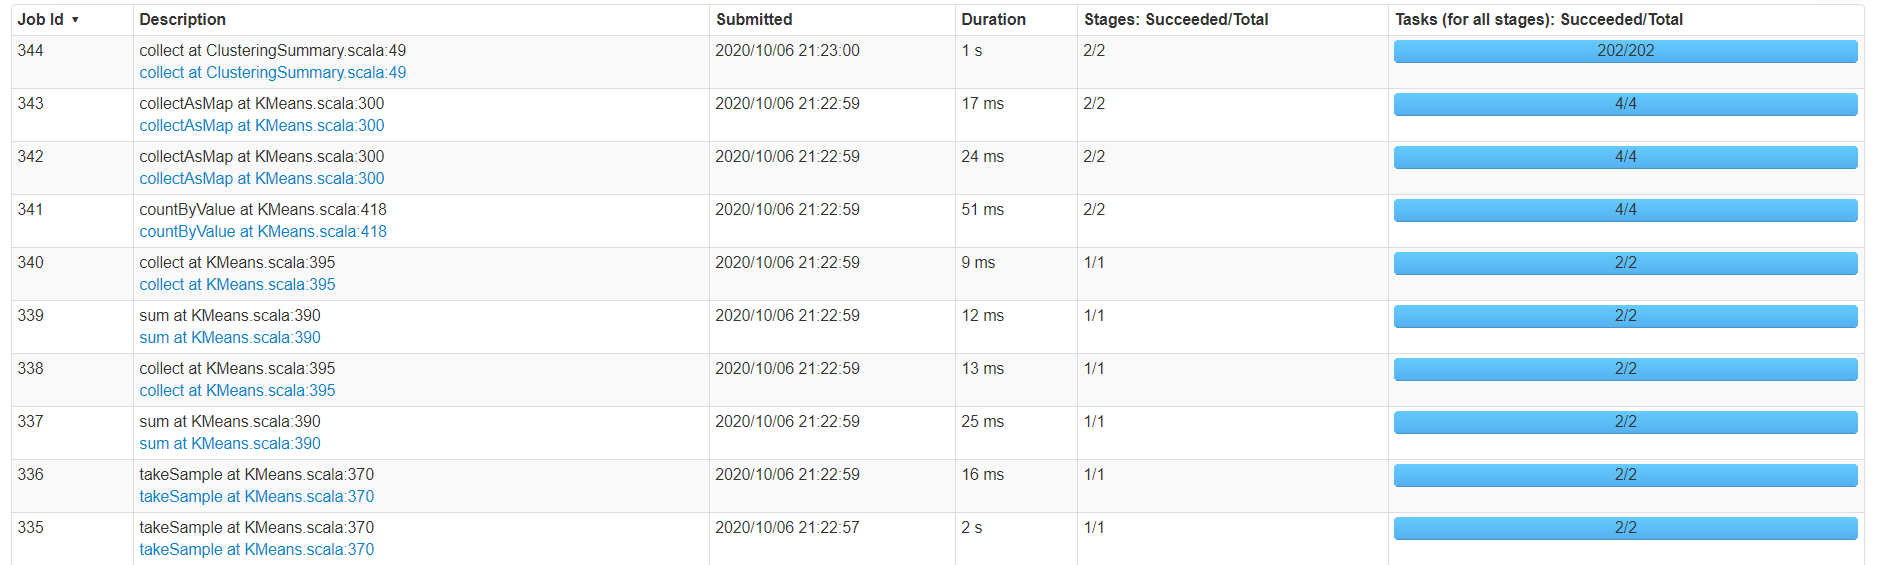

#### 3
#### This is the job page on the spark UI.
#### We can see that a total of 10 jobs (Job Id : 335-344) are executed for the KMEANS task. We also observe that there are a total of 16 stages for the KMEANS task.
#### Job Id - 335: takeSample at Kmeans scala:370 - A sample of the data is taken and paralleized for pyspark. This job has 1 stage and 2 tasks.
#### Job Id - 337: sum at Kmeans.scala:390 - The distance of the 3 nearest points is calculated. This job has 1 stage and 2 tasks.
#### Job Id - 338: collect at Kmeans.scala:395 - The distance data is collected. This job has 1 stage and 2 tasks.
#### Job Id - 341: countByValue at KMeans.scala:418 - The points are sorted according to their distance and prediction is done. This job has 2 stage and 4 tasks.
#### Job Id - 343: collectAsMap at KMeans.scala:300 - The predicted data is collected. This job has 2 stage and 4 tasks.
#### Job Id - 344: collect at ClusteringSummary.scala:49 - The data for two partitions is mapped into one. This job has 2 stage and 202 tasks.